In [1]:
import torch
import gym
import pygame
import sys
import time
import matplotlib
import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl ; mpl.use("Agg")
from mpl_toolkits.axes_grid1 import ImageGrid

from play import *
from Grad_CAM import Grad_CAM
from model import ActorCritic
from rollout import *

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


## Import Model and Get Environment

In [2]:
env_name = 'Pong-v4'
save_dir = 'figures/'

print("set up dir variables and environment...")
load_dir = 'pretrained/A3C_Pong_Full.pth'
env = gym.make(env_name) ; env.seed(2)

print("initialize agent and try to load saved weights...")
model = ActorCritic(num_inputs=1, action_space=env.action_space)
_ = model.load_state_dict(torch.load((load_dir))) ; torch.manual_seed(2)

set up dir variables and environment...
initialize agent and try to load saved weights...


In [3]:
print("get a rollout of the policy...")
history = rollout(model, env, max_ep_len=3e3)

get a rollout of the policy...


## Plot a State Frame

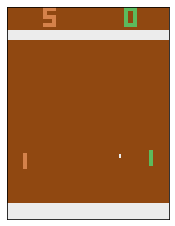

In [4]:
f = plt.figure(figsize=[3,3*1.3])
frame_ix=300
plt.imshow(history['ins'][frame_ix])
for a in f.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False)
plt.show(f)

## Create Grad-CAM Model

In [5]:
gcam = Grad_CAM(model=model)
actions = env.unwrapped.get_action_meanings()
print(actions)

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [6]:
# get input
tens_state = torch.Tensor(prepro(history['ins'][frame_ix]))
state = Variable(tens_state.unsqueeze(0), requires_grad=True)
hx = Variable(torch.Tensor(history['hx'][frame_ix-1]).view(1,-1))
cx = Variable(torch.Tensor(history['cx'][frame_ix-1]).view(1,-1))

# forward pass
probs, ids = gcam.forward(state, (hx, cx))
print('probs: {0}   ids: {1}'.format(probs, actions[ids[0]]))

probs: tensor([0.1911, 0.1827, 0.1705, 0.1702, 0.1502, 0.1352])   ids: NOOP


### Generate Grad-CAM heatmap for a single frame

In [7]:
# generate heatmap w.r.t. top predicted action
gcam.backward(idx=ids[0])
regions = gcam.generate(target_layer='features.elu4')

## Visualize

In [8]:
import cv2
def get_cam(img, mask):

    '''
    Place MASK heatmap on IMG
    '''
    h, w, _ = img.shape
    mask = cv2.resize(mask, (w, h))
    heatmap = cv2.cvtColor(cv2.applyColorMap(np.uint8((mask / np.max(mask)) * 255.0), cv2.COLORMAP_JET),
                           cv2.COLOR_BGR2RGB)
    alpha = .5
    cam = heatmap*alpha + np.float32(img)*(1-alpha)
    cam /= np.max(cam)
    return cam 

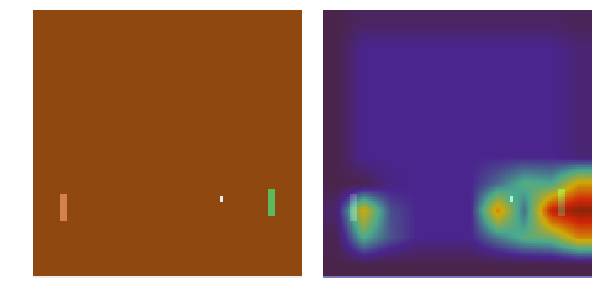

In [10]:
img = history['ins'][frame_ix]
cam = get_cam(img[35:195], regions)

fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [img[35:195],cam]):
    ax.axis('off')
    ax.imshow(im)